In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
# ALL PARAMS

m_NaCl = 500 #g
m_CaCO3 = 100 #g
m_MgCl2 = 100 #g
pH = 6 #of liquid phase
F_i = 51 #L/h
F_e = 51 #L/h
F_ag = 18 #L/h
c_Sin = 60 #g/L
T_in = 273 + 25 # K
T_inag = 273 + 15 # K

A_1 = 9.5e8
A_2 = 2.55e33
A_T = 1 #m2
C_heatag = 4.18 #J/g/K
C_heatr = 4.18 #J/g/K
E_a1 = 55000 #J/mol
E_a2 = 220000 #J/mol
H_Na = -0.550
H_Ca = -0.303
H_Mg = -0.314
H_H = -0.774
H_Cl = 0.844
H_CO3 = 0.485
H_HO = 0.941
kla_0 = 38 #1/hr
K_O2 = 8.86 #mg/L
K_P =  0.139 #g/L
K_P1 = 0.070 #g/L
K_S = 1.030 #g/L
K_S1 = 1.680 #g/L
K_T = 3.6e5 #J/h/m2/K
R_SP = 0.435
R_SX = 0.607
V = 1000 #L
V_j = 50 #L
Y_O2 = 0.970 #mg/mg
deltaH_r = 518 #kJ/molO2
mu_O2 = 0.5 #1/hr
mu_P = 1.790 #1/hr
rho_ag = 1000 #g/L
rho_r = 1080 #g/L

# gas constant
Rg = 8.314 # J/mol K

# molar masses (g/mol)
M_Na = 22.99 
M_NaCl = 58.44
M_Ca = 40.08
M_CaCO3 = 100.09
M_Mg = 24.31
M_MgCl2 = 95.21
M_Cl = 35.45
M_CO3 = 60.01

In [ ]:
# steady state input variables
Fi = 51
Fe = 51
Tin = 25
Cs_in = 60
Tin_ag = 15
F_ag = 18

# steady state state variables
Cx = 0.905
Cp = 12.5
Cs = 29
Co2 = 3.11
Tr = 29.57
Tag = 27.05
V = Fe*Cp*np.exp(K_P1*Cp)*(K_S1+Cs)/(mu_P*Cx*Cs)

In [ ]:
def mu_x(Tr):
  return A_1*np.exp(-1*(E_a1/(Rg*(Tr + 273)))) - A_2*np.exp(-1*(E_a2/(Rg*(Tr + 273))))


def kla(Tr):
  return kla_0 * 1.024**(Tr-20)

def dkla(Tr):
  return kla_0*(1.024**(Tr-20))*np.log(1.024)

def Co2_star0(Tr, V):
  # molar concentration calculations (ions)
  c_Na = m_NaCl*M_Na / (M_NaCl*V)
  c_Ca = m_CaCO3*M_Ca / (M_CaCO3*V)
  c_Mg = m_MgCl2*M_Mg / (M_MgCl2*V)
  c_Cl = (m_NaCl/M_NaCl + 2*m_MgCl2/M_MgCl2) * M_Cl/V
  c_CO3 = m_CaCO3*M_CO3 / (M_CaCO3*V)

  # concentration from pH
  c_H = 10**(-pH)
  c_OH = 10**(pH-14)

  # Ionic strength calculations (Eq 18)
  I_Na = 0.5*c_Na
  I_Ca = 0.5*c_Ca*(2**2)
  I_Mg = 0.5*c_Mg*(2**2)
  I_Cl = 0.5*c_Cl
  I_CO3 = 0.5*c_CO3*(2**2)
  I_H = 0.5*c_H
  I_OH = 0.5*c_OH

  # global effect of ionic strengths (Eq 26)
  ionic_strengths = np.array ([I_Na, I_Ca, I_Mg, I_Cl, I_CO3, I_H, I_OH])
  Hs = np.array ([H_Na, H_Ca, H_Mg, H_Cl, H_CO3, H_H, H_HO])

  global_eff = np.dot (ionic_strengths, Hs)

  # (Eq 27) equilibrium conc of O2 in H2O
  Cstar_0 = 14.6 - 0.3943*Tr + 7.714e-3*(Tr**2) - 6.46e-5*(Tr**3)

  return Cstar_0, global_eff

def Co2_star(Tr, V):
  Cstar_0, global_eff = Co2_star0(Tr, V)

  # (Eq 28)
  Cstar = Cstar_0 * 10**(-global_eff) 

  return Cstar

def dCo2_star_Tr(Tr, V):
  Cstar_0, global_eff = Co2_star0(Tr, V)

  return 10**(-global_eff) * -0.3943 * 2*0.007714*Tr - 3*0.0000646*Tr**2

def d10(V):
  # molar concentration calculations (ions)
  c_Na = m_NaCl*M_Na / (M_NaCl*V)
  c_Ca = m_CaCO3*M_Ca / (M_CaCO3*V)
  c_Mg = m_MgCl2*M_Mg / (M_MgCl2*V)
  c_Cl = (m_NaCl/M_NaCl + 2*m_MgCl2/M_MgCl2) * M_Cl/V
  c_CO3 = m_CaCO3*M_CO3 / (M_CaCO3*V)

  # concentration from pH
  c_H = 10**(-pH)
  c_OH = 10**(pH-14)

  # Ionic strength calculations (Eq 18)
  I_Na = 0.5*c_Na
  I_Ca = 0.5*c_Ca*(2**2)
  I_Mg = 0.5*c_Mg*(2**2)
  I_Cl = 0.5*c_Cl
  I_CO3 = 0.5*c_CO3*(2**2)
  I_H = 0.5*c_H
  I_OH = 0.5*c_OH

  # global effect of ionic strengths (Eq 26)
  ionic_strengths = np.array ([I_Na, I_Ca, I_Mg, I_Cl, I_CO3, I_H, I_OH])
  Hs = np.array ([H_Na, H_Ca, H_Mg, H_Cl, H_CO3, H_H, H_HO])

  global_eff = np.dot (ionic_strengths, Hs)

  return 10**(-global_eff) * np.log(10) * -1*(-1/V)*(H_Na*I_Na+H_Ca*I_Na+H_Mg*I_Mg + H_Cl*I_Cl + H_CO3*I_CO3)

In [ ]:
# make A (partial derivatives with respect to state variables)

# derivatives of f1 (dVdt)
A11 = 0 # V
A12 = 0 # Cx
A13 = 0 # CP
A14 = 0 # Cs
A15 = 0 # CO2
A16 = 0 # Tr
A17 = 0 # Tag

# derivatives of f2 (dCxdt)
A21 = Fe*Cx/V**2 
A22 = mu_x(Tr)*(Cs/(K_S+Cs))*np.exp(-K_P*Cp) - Fe/V 
A23 = -mu_x(Tr)*Cx*(Cs/(K_S+Cs))*np.exp(-K_P*Cp)*K_P
A24 = K_S*mu_x(Tr)*Cx*np.exp(-K_P*Cp)/(K_S+Cs)**2
A25 = 0
A26 = (Cx*Cs*np.exp(-K_P*Cp)/(K_S+Cs))*(A_1*E_a1*np.exp(-1*(E_a1/(Rg*(Tr + 273))))/(Rg*(Tr+273)**2) - A_2*E_a2*np.exp(-1*(E_a2/(Rg*(Tr + 273))))/(Rg*(Tr+273)**2))
A27 = 0

# derivatives of f3 (dCpdt)
A31 = Fe*Cp/V**2 
A32 = mu_P*(Cs/(K_S1+Cs))*np.exp(-K_P1*Cp)
A33 = -K_P1*mu_P*Cx*(Cs/(K_S1+Cs))*np.exp(-K_P1*Cp) - Fe/V
A34 = K_S1*mu_P*Cx*np.exp(-K_P1*Cp)/(K_S1+Cs)**2
A35 = 0
A36 = 0
A37 = 0

# derivatives of f4 (dCsdt)
A41 = (Fe*Cs -Fi*Cs_in)/V**2
A42 = -mu_P*(Cs/(K_S1+Cs))*np.exp(-K_P1*Cp)/R_SP - mu_x(Tr)*(Cs/(K_S+Cs))*np.exp(-K_P*Cp)/R_SX
A43 = (-mu_P*(Cs/(K_S1+Cs))*np.exp(-K_P1*Cp)*(-K_P1)/R_SP - mu_x(Tr)*(Cs/(K_S+Cs))*np.exp(-K_P*Cp)*(-K_P)/R_SX)*Cx
A44 = -(K_S*mu_x(Tr)*Cx*np.exp(-K_P*Cp)/(K_S+Cs)**2)/R_SX - (K_S1*mu_P*Cx*np.exp(-K_P1*Cp)/(K_S1+Cs)**2)/R_SP - Fe/V
A45 = 0
A46 = -A26/R_SX
A47 = 0

# derivatives of f5 (dCO2dt)
A51 = kla(Tr)*(14.6-0.3943*Tr+7.714e-3*(Tr**2)-6.46e-5*(Tr**3))*d10(V)
A52 = -mu_O2*(1/Y_O2)*Co2/(K_O2+Co2)*1/1000
A53 = 0
A54 = 0
A55 = -kla(Tr)-1/1000*mu_O2*(1/Y_O2)*Cx*K_O2/(K_O2-Co2)**2
A56 = dkla(Tr)*(Co2_star(Tr, V)-Co2) - Co2*dCo2_star_Tr(Tr, V)
A57 = 0

# derivatives of f6 (dTrdT)
A61 = -1/(V**2)*(Fi*(Tin+273) + Fe*(Tr+273) + K_T*A_T*(Tr-Tag)/(rho_r*C_heatr))
A62 = deltaH_r/(32*rho_r*C_heatr)*mu_O2*(1/Y_O2)*(Co2/K_O2+Co2)
A63 = 0
A64 = 0
A65 = deltaH_r/(32*rho_r*C_heatr)*mu_O2*(1/Y_O2)*Cx*K_O2/(K_O2-Co2)**2
A66 = -Fe/V + K_T*A_T/(V*rho_r*C_heatr)
A67 = -K_T*A_T/(V*rho_r*C_heatr)

# derivative of f7 (dTagdt)
A71 = 0
A72 = 0
A73 = 0
A74 = 0
A75 = 0
A76 = K_T*A_T/(V_j*rho_ag*C_heatag)
A77 = -F_ag/V_j - K_T*A_T/(V_j*rho_ag*C_heatag)

# create A
A = np.array([[A11, A12, A13, A14, A15, A16, A17],
              [A21, A22, A23, A24, A25, A26, A27],
              [A31, A32, A33, A34, A35, A36, A37],
              [A41, A42, A43, A44, A45, A46, A47],
              [A51, A52, A53, A54, A55, A56, A57],
              [A61, A62, A63, A64, A65, A66, A67],
              [A71, A72, A73, A74, A75, A76, A77]])
A

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.62734137e-05,  5.27352126e-04, -6.49010774e-03,
         5.52231277e-05,  0.00000000e+00,  3.37305809e-03,
         0.00000000e+00],
       [ 6.39135548e-04,  7.05322928e-01, -9.57475875e-02,
         1.20529265e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.58505616e-03, -1.70642828e+00,  1.13409823e-01,
        -5.39271449e-02,  0.00000000e+00, -5.55693260e-03,
         0.00000000e+00],
       [ 7.81362648e-02, -1.33925880e-04,  0.00000000e+00,
         0.00000000e+00, -4.76820941e+01,  4.25431598e+00,
         0.00000000e+00],
       [-3.09091234e-02,  6.39707727e-03,  0.00000000e+00,
         0.00000000e+00,  4.48254467e-04,  2.87816663e-02,
        -7.98470463e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.72248804e+00,
        -2.0824880

In [ ]:
# make B (partial derivatives with respect to inputs)

# derivatives of f1 (dVdt)
B11 = 1  # Fi
B12 = -1 # Fe
B13 = 0  # Tin
B14 = 0  # Cs_in
B15 = 0  # Tin_ag
B16 = 0  # F_ag

# derivativese of f2 (dCxdt)
B21 = 0
B22 = -1*Cx/V
B23 = 0
B24 = 0
B25 = 0
B26 = 0

# derivatives of f3 (dCpdt)
B31 = 0
B32 = -1*Cp/V
B33 = 0
B34 = 0
B35 = 0
B36 = 0

# derivatives of f4 (dCsdt)
B41 = Cs_in/V
B42 = Cs/V
B43 = 0
B44 = Fi/V
B45 = 0
B46 = 0

# derivatives of f5 (dCO2dt)
B51 = 0
B52 = 0
B53 = 0
B54 = 0
B55 = 0
B56 = 0

# derivatives of f6 (dTrdT)
B61 = 1/V * (Tin + 273)
B62 = -1/V * (Tr + 273)
B63 = Fi/V
B64 = 0
B65 = 0
B66 = 0

# derivatives of f7 (dTagdt)
B71 = 0
B72 = 0
B73 = 0
B74 = 0
B75 = F_ag/V_j
B76 = 1/V_j*(Tin_ag-Tag)

# create B
B = np.array([[B11, B12, B13, B14, B15, B16],
              [B21, B22, B23, B24, B25, B26],
              [B31, B32, B33, B34, B35, B36],
              [B41, B42, B43, B44, B45, B46],
              [B51, B52, B53, B54, B55, B56],
              [B61, B62, B63, B65, B65, B66],
              [B71, B72, B73, B74, B75, B76]])

In [ ]:
# create C
C = np.eye(7)
C

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
# create D
D = np.zeros((7,6))
D

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
continuous_model = signal.StateSpace(A, B, C, D)
continuous_model

StateSpaceContinuous(
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.62734137e-08,  5.27352126e-07, -6.49010774e-06,
         5.52231277e-08,  0.00000000e+00,  3.37305809e-06,
         0.00000000e+00],
       [ 6.39135548e-07,  7.05322928e-04, -9.57475875e-05,
         1.20529265e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.58505616e-06, -1.70642828e-03,  1.13409823e-04,
        -5.39271449e-05,  0.00000000e+00, -5.55693260e-06,
         0.00000000e+00],
       [ 7.81362648e-05, -1.33925880e-07,  0.00000000e+00,
         0.00000000e+00, -4.76820941e-02,  4.25431598e-03,
         0.00000000e+00],
       [-3.09091234e-05,  6.39707727e-06,  0.00000000e+00,
         0.00000000e+00,  4.48254467e-07,  2.87816663e-05,
        -7.98470463e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.72248804e-

In [ ]:
discrete_model = continuous_model.to_discrete(dt = 1)
discrete_model

StateSpaceDiscrete(
array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.62191785e-08,  1.00000053e+00, -6.48979562e-06,
         5.52177422e-08,  7.44127530e-13,  3.37310729e-06,
        -1.34572242e-10],
       [ 6.39120302e-07,  7.05288320e-04,  9.99904255e-01,
         1.20522193e-06,  1.75143785e-16,  1.18617133e-09,
        -3.15545117e-14],
       [-1.58493075e-06, -1.70634275e-03,  1.13406874e-04,
         9.99946074e-01, -1.22631289e-12, -5.55974049e-06,
         2.21773102e-10],
       [ 7.62379565e-05, -1.17389131e-07,  3.98666835e-13,
        -3.39206816e-15,  9.53436843e-01,  4.15454185e-03,
        -1.67064759e-07],
       [-3.09095501e-05,  6.39717083e-06, -2.07583936e-11,
         1.76623516e-13,  4.37741802e-07,  1.00002871e+00,
        -7.97651102e-05],
       [-2.66020734e-08,  5.50567579e-09, -1.19125593e-14,
         1.01359261e-16,  3.79731907e-10,  1.72072048e-03

In [ ]:
# step response model
x0 = np.array([V, Cx, Cp, Cs, Co2, Tr, Tag])
step, output_response = signal.dstep(discrete_model, x0 = x0, n = 300)

In [ ]:
step

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [ ]:
# get output response
Fi_response = output_response[0]
Fe_response = output_response[1]
Tin_response = output_response[2]
Cs_in_response = output_response[3]
Tin_ag_response = output_response[4]
F_ag_response = output_response[5]

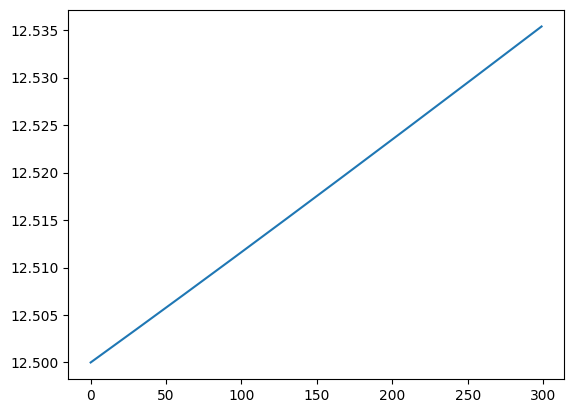

In [ ]:
plt.plot(step, F_ag_response.T[2])